<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/brace_adjust_padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [3]:
%ls

 angleModel1/      dataset_pytorch.py        labels                  test_subset.pkl
 annotations/      figures/                  lstm_model2.pth         timeDistModel/
 bracedataset.py   head_floor.PNG            lstm_model.pth          train_subset.pkl
 brace_test.pkl    hip_knee_ankle.PNG       'MODELS ACCURACY.gdoc'   utils/
 brace_test.pth    hip_knee_horizontal.PNG   names                   videos_info.csv
 brace_train.pkl   keras_model/              path/                   wrists_floor.PNG
 brace_train.pth   keypoints_angles.py       __pycache__/
 dataClips         k_model_features/         README.md
 dataset/          k_model_features2/        tensor_dataset.pkl


In [4]:
pip install dtaidistance

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone/brace')

In [19]:
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from pathlib import Path

In [51]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import bracedataset
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset
from tqdm import tqdm
from pathlib import PosixPath
import pickle
import re
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.optim.lr_scheduler import ExponentialLR
import json
from pathlib import Path

from dtaidistance import dtw
from dtaidistance import dtw
from dtaidistance import clustering
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Obtain BRACE dataset clips and labels, only need to to this once, they are saved for future reference


In [7]:
####### Load one


# #load paths
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels, names=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# with open("dataClips", "wb") as fp:   #Pickling
#     pickle.dump(dataClips, fp)
# with open("labels", "wb") as fp:   #Pickling
#     pickle.dump(labels, fp)
# with open("names", "wb") as fp:   #Pickling
#     pickle.dump(names, fp)

In [11]:
#load segment
segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# Load the TensorDataset
with open('dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]

Categories= {'toprock': 0, 'powermove': 1, 'footwork': 2}

In [16]:
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]
padded_clips = pad_sequences(flattened_clips, padding='post', dtype='float32')

CNN model with RNN layer


In [20]:
### KERAS CNN MODEL######

X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2])),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17000     
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 16s 471ms/step - loss: 1.0997 - accuracy: 0.2882 - val_loss: 1.0995 - val_accuracy: 0.2949
Epoch 2/1

In [22]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 3s 277ms/step - loss: 1.0978 - accuracy: 0.3616
Test accuracy: 0.361623615026474


Change the padding to trucated


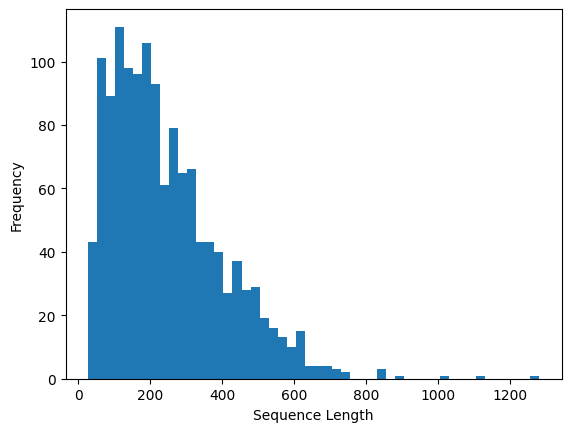

In [23]:
sequence_lengths = [len(seq) for seq in flattened_clips]

plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determine a suitable maxlen based on the distribution, for example, the 90th percentile
maxlen = np.percentile(sequence_lengths, 90)

In [28]:
padded_clips = pad_sequences(flattened_clips, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2])),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=8, batch_size=32, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                17000     
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/8
27/27 [==============================] - 11s 181ms/step - loss: 1.1098 - accuracy: 0.3137 - val_loss: 1.0789 - val_accuracy: 0.4240
Epoch 2/

In [29]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 1s 62ms/step - loss: 0.5871 - accuracy: 0.7269
Test accuracy: 0.7269372940063477


9/9 [==============================] - 1s 60ms/step
              precision    recall  f1-score   support

           0       0.84      0.99      0.91        98
           1       0.78      0.60      0.68        98
           2       0.51      0.55      0.53        75

    accuracy                           0.73       271
   macro avg       0.71      0.71      0.71       271
weighted avg       0.73      0.73      0.72       271



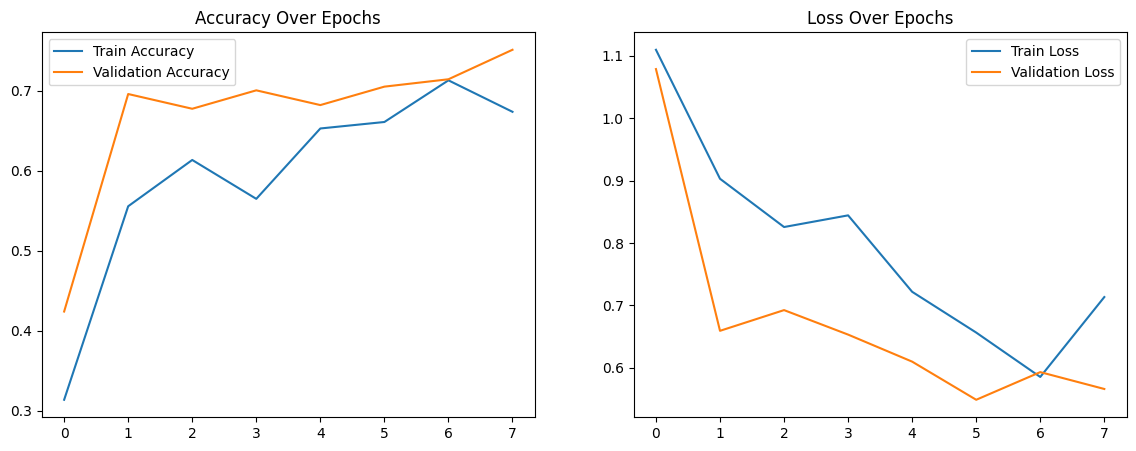

In [30]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
# Plotting confusion matrix or use seaborn for a nicer plot

# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

INCLUDE FEATURES IN THE MODEL

In [35]:
#sort additional features
features= segments.copy()
features['uid']= pd.Categorical(features['uid'], categories=names, ordered=True)
features= features.sort_values(by='uid')
features['frames']= features['end_frame']- features['start_frame']


In [36]:
# One-hot encode
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('cat', OneHotEncoder(), ['dancer_id']),
        ('num', OneHotEncoder(), ['year']),

    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'dancer_id', 'year']])
features_preprocessed = features_preprocessed.toarray()


In [37]:
#padded trucated
padded_clips = pad_sequences(flattened_clips, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')
# split train, test
X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

In [39]:
# CNN with features
# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50)(keypoint_input)
keypoint_model = Dense(100, activation='relu')(keypoint_model)

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu')(additional_features_input)

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 471, 34)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_4 (LSTM)               (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 78)]                 0         []                            
 )                                                                                                
                                                                                            

In [40]:
#training set
history = model.fit([X_train_clips, X_train_features], y_train_onehot, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
27/27 [==============================] - 9s 238ms/step - loss: 1.1021 - accuracy: 0.3715 - val_loss: 1.0931 - val_accuracy: 0.3410
Epoch 2/10
27/27 [==============================] - 5s 190ms/step - loss: 0.9820 - accuracy: 0.4977 - val_loss: 0.6773 - val_accuracy: 0.7005
Epoch 3/10
27/27 [==============================] - 8s 295ms/step - loss: 0.9647 - accuracy: 0.5150 - val_loss: 1.1005 - val_accuracy: 0.3502
Epoch 4/10
27/27 [==============================] - 7s 250ms/step - loss: 1.1080 - accuracy: 0.3391 - val_loss: 1.1080 - val_accuracy: 0.2857
Epoch 5/10
27/27 [==============================] - 7s 246ms/step - loss: 1.0632 - accuracy: 0.4410 - val_loss: 1.0203 - val_accuracy: 0.5300
Epoch 6/10
27/27 [==============================] - 4s 167ms/step - loss: 0.8296 - accuracy: 0.6204 - val_loss: 0.6287 - val_accuracy: 0.7097
Epoch 7/10
27/27 [==============================] - 5s 169ms/step - loss: 0.6287 - accuracy: 0.7222 - val_loss: 0.4510 - val_accuracy: 0.7327
Epoch 

In [41]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 1s 64ms/step - loss: 0.4491 - accuracy: 0.7823
Test Loss: 0.4491393566131592
Test Accuracy: 0.7822878360748291


CHANGE FEATURES TO SEQUENCE AND CLIP LENGHT, TO TEST IF THERE IS LESS OVERFITTING